## Import and formatting

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date, time
import math

In [47]:
df_LA = pd.read_csv("../data/LA.csv") 

In [48]:
#transform columns start_time and end_time into datetime
df_LA['start_time'] = pd.to_datetime(df_LA['start_time'])
df_LA['end_time'] = pd.to_datetime(df_LA['end_time'])
df_LA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306870 entries, 0 to 306869
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   start_time              306870 non-null  datetime64[ns]
 1   end_time                306870 non-null  datetime64[ns]
 2   start_station_id        306870 non-null  int64         
 3   end_station_id          306870 non-null  int64         
 4   bike_id                 306870 non-null  int64         
 5   user_type               306870 non-null  object        
 6   start_station_name      306870 non-null  object        
 7   end_station_name        306870 non-null  object        
 8   trip_duration           306870 non-null  object        
 9   trip_duration_in_hours  306870 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(4)
memory usage: 23.4+ MB


## A firste explorative look

At first we have a look at how many rides were done by each user type:

In [49]:
df_LA.groupby("user_type").count()["start_time"].sort_values()

user_type
Annual Pass       2049
Flex Pass         6739
One Day Pass     16957
Walk-up         120351
Monthly Pass    160774
Name: start_time, dtype: int64

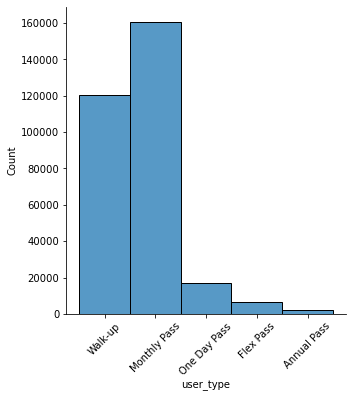

In [50]:
sns.displot(df_LA["user_type"]).set_xticklabels(rotation=45)

## The pricing system

Below the prices are listed which are in place at the moment (december 2021): https://t1p.de/xop9n<br>
The same prices have been in place since August of 2018: https://t1p.de/6cep

<table style="float: left">
  <tr>
    <th>"user_type" in dataset</th>
    <th>name on website</th>
    <th>pricing</th>
  </tr>
  <tr>
    <td>Annual Pass</td>
    <td>365-Day PAss</td>
    <td>150/year & 1,75 after 30min</td>
  </tr>
  <tr>
    <td>Flex Pass</td>
      <td>(does not exist)</td>
    <td>/</td>
  </tr>
  <tr>
    <td>Monthly Pass</td>
    <td>30-Day Pass </td>
    <td>17/month & 1.75 after 30min</td>
  </tr>
  <tr>
    <td>One Day Pass</td>
    <td>24-Hour Access</td>
    <td>5/day & 1.75 after 30min</td>
  </tr>
  <tr>
    <td>Walk-Up</td>
    <td>1-Ride</td>
    <td>1.75 per 30min</td>
  </tr>
</table>


In June 2016 the following princing system was in place: https://t1p.de/spq7

<table style="float: left">
  <tr>
    <th>"user_type" in dataset</th>
    <th>name on website</th>
    <th>pricing</th>
  </tr>
  <tr>
    <td>Annual Pass</td>
    <td>(does not exist)</td>
    <td>/</td>
  </tr>
  <tr>
    <td>Flex Pass</td>
      <td>Flex Pass</td>
    <td>40/year & 1.75 after 30min</td>
  </tr>
  <tr>
    <td>Monthly Pass</td>
    <td>Monthly Pass </td>
    <td>20/month & 1.75 after 30min</td>
  </tr>
  <tr>
    <td>One Day Pass</td>
    <td>(does not exist)</td>
    <td>/</td>
  </tr>
  <tr>
    <td>Walk-Up</td>
    <td>1-Ride</td>
    <td>3.50 per 30min</td>
  </tr>
</table>

Prices have changed within 2018. Unfortunately, there is no information on the Internet about what the prices were at the beginning of 2018. <br>
We now take a look at how often rides were started by the different user_types:

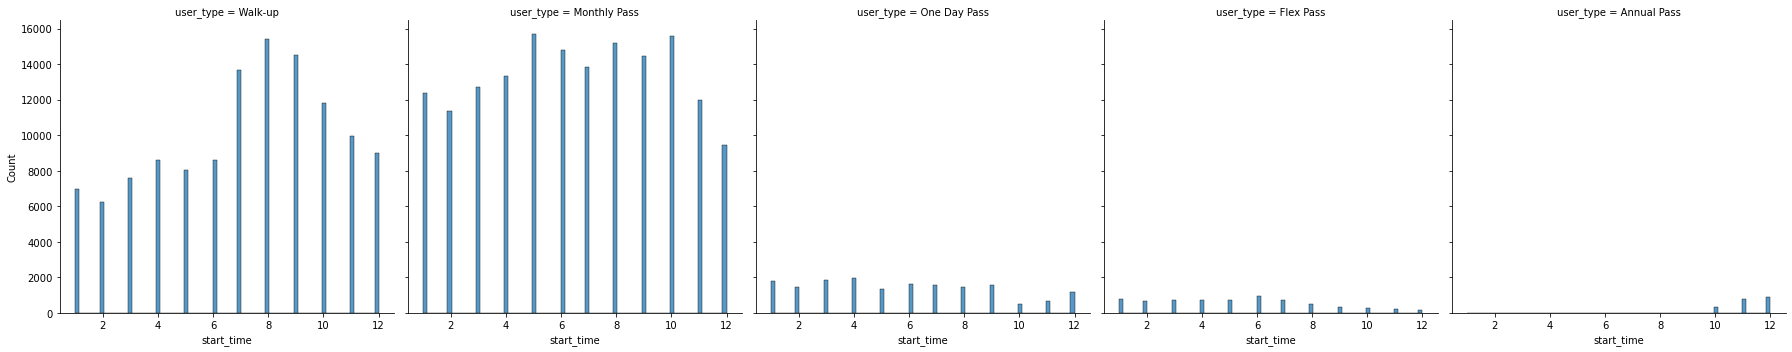

In [51]:
df_temp = df_LA.copy()
df_temp["start_time"] = df_temp["start_time"].dt.month


sns.displot(df_temp, x="start_time", col="user_type")

#sns.displot(df_Annual, x="start_time", hue="user_type", multiple = "stack")


Having a closer look at the Annual Pass, because there were no rides in the first 8 months.

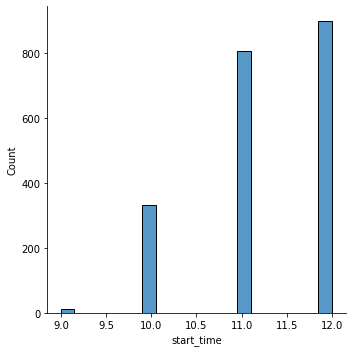

In [52]:
sns.displot(df_temp[df_temp["user_type"] == "Annual Pass"], x="start_time")

In [53]:
df_LA[df_LA["user_type"] == "Annual Pass"]["start_time"].describe(datetime_is_numeric=True)

count                             2049
mean     2018-11-24 10:45:31.039531264
min                2018-09-29 13:52:00
25%                2018-11-08 15:06:00
50%                2018-11-27 09:46:00
75%                2018-12-13 09:05:00
max                2018-12-31 22:46:00
Name: start_time, dtype: object

The first time a ride with the Annual Pass took place was on 2018-09-29. This observation is consistent with the information from above that the pricing system changed within 2018. The Annual Pass was probably only introduced within 2018.

### Quantity of bought passes

The data does not include a User_ID or anything else that would allow us to deduce the number of passes sold. There was also no information on the Internet about how many passes were sold in 2018. <br>
We therefore have to leave out the revenue generated by the sale of passes from our analysis.

### Final determination of a pricing model for the analysis

From the information above, we determine the following specifications for later analysis.

**1:** We only pay attention to the fares that are payed by time, not the pre paid passes *(because we unfortunately do not have any user data)* <br>
**2:** We use for all user_types for which it is possible the prices that applyed from August 2020 *(because we have no information on the prices in the first half of 2018)*<br>
**2.1:** Because we only look at the fares that are paid by time (compare 1. specification) we don't have to set a prepaid price for the Fix Pass. The faires after 30 minutes we declare as 1.75 <br>

*(This means that in the analysis for all user_types except "walk-up" we calculate 1.75 for all started 30 minutes after the first 30 minutes and for "walk-up" we calculate 1.75 for all started 30 minutes.)* <br>



**3:** The price of a ride is credited to the hour in which the ride ends.

## Calculation of revenues

In [85]:
df_rev = df_LA.copy()


#df_rev.loc[df_rev["user_type"] == "Walk-up", "revenue"] = round(df_LA["trip_duration_in_hours"]*2 , 0)*1.75
#df_rev.loc[df_rev["user_type"] != "Walk-up", "revenue"] = round(df_LA["trip_duration_in_hours"]*2 -1, 0)*1.75

df_rev.loc[df_rev["user_type"] == "Walk-up", "revenue"] = np.ceil(df_LA["trip_duration_in_hours"]*2) *1.75
df_rev.loc[df_rev["user_type"] != "Walk-up", "revenue"] = np.ceil(df_LA["trip_duration_in_hours"]*2) *1.75 -1.75

df_rev[["user_type", "trip_duration_in_hours", "revenue"]].head(10)

,user_type,trip_duration_in_hours,revenue
0,Walk-up,0.350000,1.75
1,Walk-up,0.333333,1.75
2,Walk-up,0.316667,1.75
3,Monthly Pass,0.366667,0.00
4,Monthly Pass,0.750000,1.75
5,Monthly Pass,0.100000,0.00
6,Walk-up,0.200000,1.75
7,Walk-up,0.216667,1.75
8,Walk-up,0.133333,1.75
9,Monthly Pass,1.966667,5.25


# Später rüber für Explorative benutzen oder so anders einpflegen

Mean of trip duration for different user_types

In [18]:
df_LA.groupby("user_type").mean()["trip_duration_in_hours"]

user_type
Annual Pass     0.177379
Flex Pass       0.229901
Monthly Pass    0.209221
One Day Pass    0.896419
Walk-up         0.703875
Name: trip_duration_in_hours, dtype: float64